Temperature shape: (366, 31, 31)
Latitude shape: (31,)
Longitude shape: (31,)
Interpolation successful!


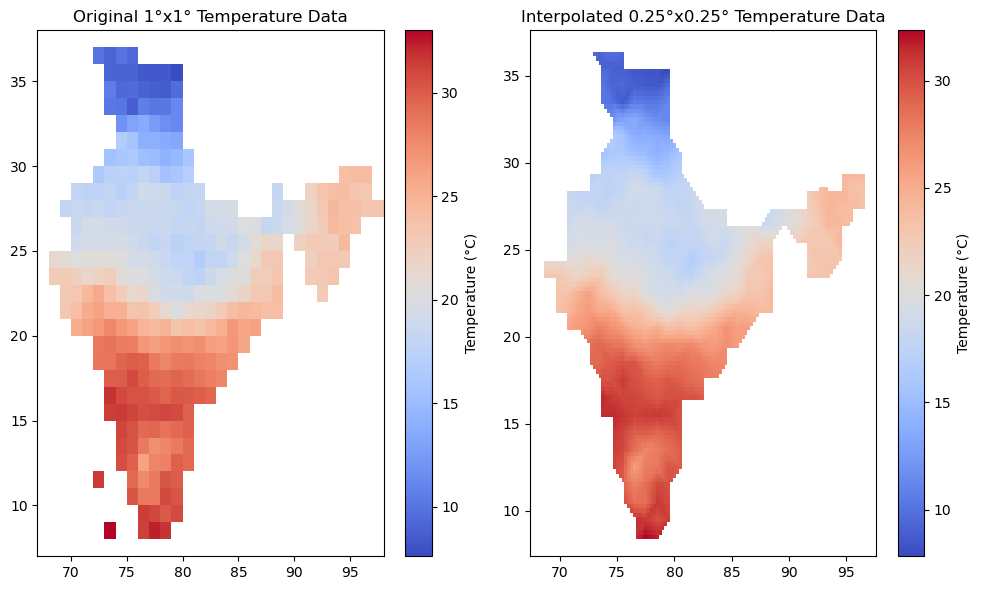

In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

nc_file = r"C:\Users\purav\OneDrive\Desktop\Fi Year Project\Final-Year-Project\Data\Temperature\Maxtemp_MaxT_2020.nc" 
ds = xr.open_dataset(nc_file)

# Extract variables
temp = ds['temperature'].values  
lat = ds['lat'].values
lon = ds['lon'].values
ds.close()

print(f"Temperature shape: {temp.shape}")  
print(f"Latitude shape: {lat.shape}")  
print(f"Longitude shape: {lon.shape}")  


temp_2d = temp[0, :, :]

if lat.shape[0] * lon.shape[0] != temp_2d.size:
    print("Mismatch in the number of points and values!")
    print(f"Expected points: {lat.shape[0] * lon.shape[0]}, but got {temp_2d.size}")

target_lats = np.arange(lat.min(), lat.max() + 0.25, 0.25)
target_lons = np.arange(lon.min(), lon.max() + 0.25, 0.25)

lon_grid, lat_grid = np.meshgrid(lon, lat)

# Target grid
target_lon_grid, target_lat_grid = np.meshgrid(target_lons, target_lats)

# Try interpolation
try:
    interpolated_temp = griddata(
        (lon_grid.flatten(), lat_grid.flatten()),  # Original points
        temp_2d.flatten(),  # Original values
        (target_lon_grid, target_lat_grid),  # Target grid
        method='linear'
    )
    print("Interpolation successful!")
except ValueError as e:
    print("Interpolation error:", e)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.pcolormesh(lon, lat, temp_2d, shading='auto', cmap='coolwarm')
plt.colorbar(label="Temperature (°C)")
plt.title("Original 1°x1° Temperature Data")

plt.subplot(1, 2, 2)
plt.pcolormesh(target_lons, target_lats, interpolated_temp, shading='auto', cmap='coolwarm')
plt.colorbar(label="Temperature (°C)")
plt.title("Interpolated 0.25°x0.25° Temperature Data")

plt.tight_layout()
plt.show()


In [1]:
import xarray as xr
import numpy as np

nc_file = r"C:\Users\purav\OneDrive\Desktop\Fi Year Project\Final-Year-Project\Data\Temperature\Maxtemp_MaxT_2020.nc" 
ds = xr.open_dataset(nc_file)

print(ds)

c:\Users\purav\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<xarray.Dataset>
Dimensions:      (time: 366, lat: 31, lon: 31)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2024-01-01
  * lat          (lat) float64 7.5 8.5 9.5 10.5 11.5 ... 34.5 35.5 36.5 37.5
  * lon          (lon) float64 67.5 68.5 69.5 70.5 71.5 ... 94.5 95.5 96.5 97.5
Data variables:
    temperature  (time, lat, lon) float32 ...
Attributes:
    description:  IMD 1°x1° Maximum Temperature Data from Maxtemp_MaxT_2020.GRD
    units:        °C


In [2]:
temperature = ds['temperature']
avg_temperature = temperature.mean(dim= 'time')
avg_temperature.to_netcdf("average_temperature.nc")

In [3]:
from scipy.interpolate import griddata
import geopandas as gpd
import pandas as pd
from scipy.spatial import cKDTree


In [4]:
grid = gpd.read_file(r"C:\Users\purav\OneDrive\Desktop\Fi Year Project\Final-Year-Project\Data\Shapefile\India Shape\grid.shp")

temperature_ds = xr.open_dataset(r"C:\Users\purav\OneDrive\Desktop\Fi Year Project\Final-Year-Project\Notebooks\average_temperature.nc")

In [5]:
lat = temperature_ds['lat'].values
lon = temperature_ds['lon'].values
temperature = temperature_ds['temperature'].values 

In [6]:
temperature_points = np.array([(lat[i], lon[j]) for i in range(len(lat)) for j in range(len(lon))])
temperature_values = temperature.flatten()

In [7]:
tree = cKDTree(temperature_points)
grid['centroid'] = grid.geometry.centroid
grid_points = np.array([(p.y, p.x) for p in grid['centroid']])
_, idx = tree.query(grid_points)
grid['temperature'] = temperature_values[idx]

In [8]:
grid[['centroid', 'temperature']].to_csv("grid_with_temperature.csv", index=False)


In [9]:
import matplotlib.pyplot as plt


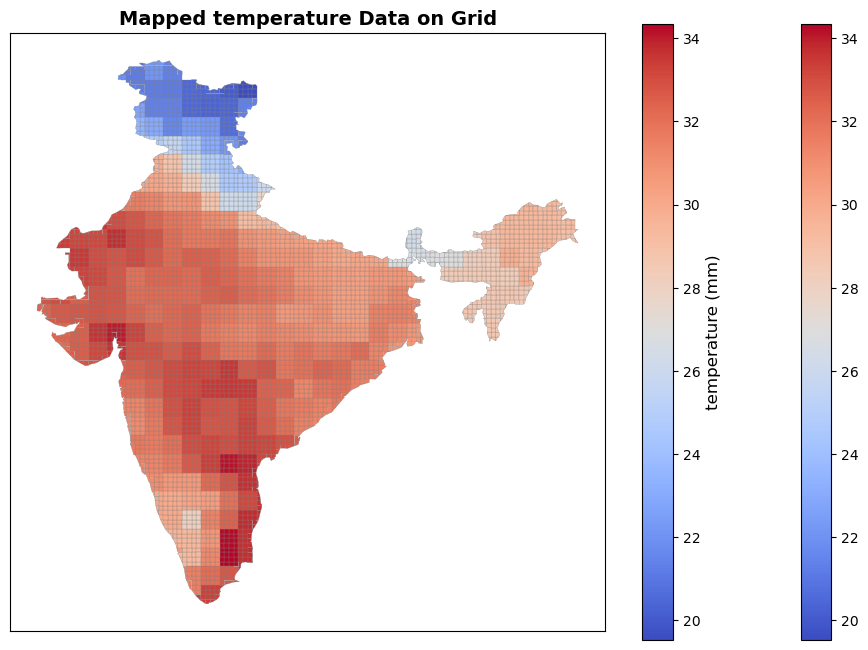

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
grid.plot(column='temperature', cmap='coolwarm', linewidth=0.2, edgecolor='gray', legend=True, ax=ax)

# Improve the colorbar & layout
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=grid['temperature'].min(), vmax=grid['temperature'].max()))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("temperature (mm)", fontsize=12)

# Remove axis labels for cleaner visualization
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Mapped temperature Data on Grid", fontsize=14, fontweight='bold')

plt.show()